In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from cycler import cycler
import pandas as pd
import xarray as xr
from netCDF4 import Dataset
from scipy.signal import windows
from matplotlib.lines import Line2D
from scipy import signal
from scipy.fft import fft, fftshift
from scipy.signal import butter, filtfilt
from matplotlib.ticker import FormatStrFormatter, MaxNLocator, FuncFormatter
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.ndimage import gaussian_filter

In [20]:
# Load data
data_east=loadmat('/Users/cristinaarumiplanas/Documents/Papers_Cristina/University_Hamburg/forCristina_202409/data/external_data/Dinezio_Wind_eastern_2_12yr.mat')
data_central=loadmat('/Users/cristinaarumiplanas/Documents/Papers_Cristina/University_Hamburg/forCristina_202409/data/external_data/Dinezio_Wind_central_2_12yr.mat')
data_west=loadmat('/Users/cristinaarumiplanas/Documents/Papers_Cristina/University_Hamburg/forCristina_202409/data/external_data/Dinezio_Wind_western_2_12yr.mat')

In [21]:
# Extract time and wind data
time_east=data_east['Dinezio_Wind_eastern_2_12yr'][:, 0]
wind_east=data_east['Dinezio_Wind_eastern_2_12yr'][:, 1]

time_central=data_central['Dinezio_Wind_central_2_12yr'][:, 0]
wind_central=data_central['Dinezio_Wind_central_2_12yr'][:, 1]

time_west=data_west['Dinezio_Wind_western_2_12yr'][:, 0]
wind_west=data_west['Dinezio_Wind_western_2_12yr'][:, 1]

In [22]:
# Define linestyles using cycler 
linestyles=plt.cm.tab10.colors[:3]

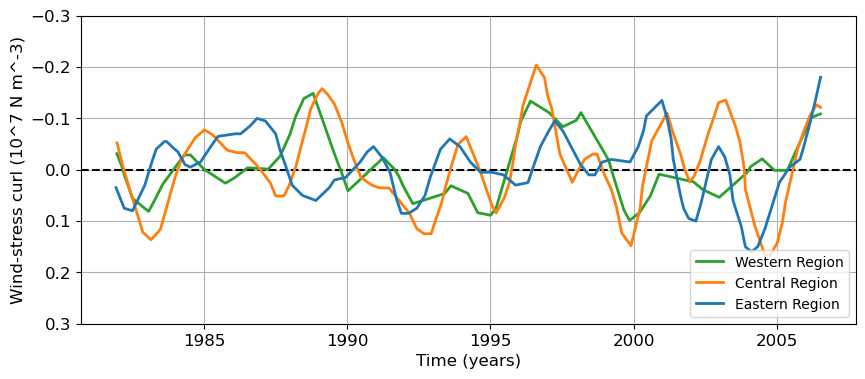

In [23]:
# Plot
plt.figure(figsize=(10, 4))
plt.axhline(y=0,color='black',linestyle='--',linewidth=1.5)#plot dashed black line in 0
plt.plot(time_west,wind_west,color=linestyles[2],linewidth=2,label='Western Region')
plt.plot(time_central,wind_central, color=linestyles[1],linewidth=2,label='Central Region')
plt.plot(time_east,wind_east,color=linestyles[0],linewidth=2,label='Eastern Region')
plt.grid(True)
plt.legend(loc='lower right',fontsize=10)
plt.ylabel('Wind-stress curl (10^7 N m^-3)',fontsize=12)
plt.xlabel('Time (years)',fontsize=12)
plt.ylim([-0.3, 0.3])
plt.gca().tick_params(axis='both',which='major',labelsize=12)
plt.gca().invert_yaxis() #invierto positivo abajo negativo arriba
plt.show()

In [24]:
#Now we compute the wind stress curl from ERA5 data
# Load ERA5 data
u10_daily=xr.open_dataset('/Users/cristinaarumiplanas/Documents/Papers_Cristina/University_Hamburg/Sverdrup/Data/Winds/u_component/daily_mean_u_wind_data_1979_2023.nc')
v10_daily=xr.open_dataset('/Users/cristinaarumiplanas/Documents/Papers_Cristina/University_Hamburg/Sverdrup/Data/Winds/v_component/daily_mean_v_wind_data_1979_2023.nc')

In [25]:
#Constants I need to compute the wind stress curl
rho_air=1.225 # Air density in kg/m3
Cd=1.3e-3 # Drag coefficient
R=6371000 #Earth Radius in m
rho0=1030 #Densidad del agua de mar en kg/m³ 1030
omega=7.2921e-5 #Earth's angular velocity in rad/s

In [26]:
# Convert longitudes fro 0:360 to -180:180
u10_daily = u10_daily.assign_coords(lon=(((u10_daily.longitude + 180) % 360) - 180))
v10_daily = v10_daily.assign_coords(lon=(((v10_daily.longitude + 180) % 360) - 180))

In [27]:
# Resample data to monthly
u10_monthly = u10_daily.resample(time='M').mean()
v10_monthly = v10_daily.resample(time='M').mean()

# Shift the time index to the 15th of each month
u10_monthly['time'] = u10_monthly['time'] + np.timedelta64(14, 'D')
v10_monthly['time'] = v10_monthly['time'] + np.timedelta64(14, 'D')

In [28]:
# Magnitude of wind speed in m/s
wind_speed = np.sqrt(u10_monthly.u10**2+v10_monthly.v10**2)
#print(wind_speed)

# Compute wind stress components (tau_x, tau_y) in N m-2 (or in Pa)
tau_x=rho_air*Cd*u10_monthly.u10*wind_speed # Zonal wind stress
tau_y=rho_air*Cd*v10_monthly.v10*wind_speed # Meridional wind stress

d_tau_y_dx=tau_y.differentiate('longitude')
d_tau_x_dy=tau_x.differentiate('latitude')

# Wind stress curl calculation N m-3
curl_tau=(d_tau_y_dx-d_tau_x_dy)/(R*np.cos(np.deg2rad(u10_monthly.latitude)))
curl_tau=curl_tau*1e9

# Average over all latitudes 29N-24N
curl_tau_lat_avg = curl_tau.mean(dim='latitude')

In [29]:
#### Next, we compute the Sverdrup transport following Duchez et al. (2014):
f=2*omega*np.sin(np.deg2rad(u10_monthly.latitude)) # Coriolis parameter (f)
beta=2*omega/R*np.cos(np.deg2rad(u10_monthly.latitude)) # Meridional Derivative of the Coriolis Parameter (beta)
f_lat_avg=f.mean(dim='latitude')
beta_lat_avg=beta.mean(dim='latitude')

V_sv=(curl_tau_lat_avg/(beta_lat_avg*rho0))#Sverdrup transport
V_ek=(-curl_tau_lat_avg/(rho0*f_lat_avg)) #Ekman contribution to Sverdrup Transport, 
V_g=(V_sv/1e9-V_ek/1e3)#.mean(dim='latitude') #Geostrophic contribution to Sverdrup Transport
#print(V_sv)
#print(V_ek)
#print(V_g)

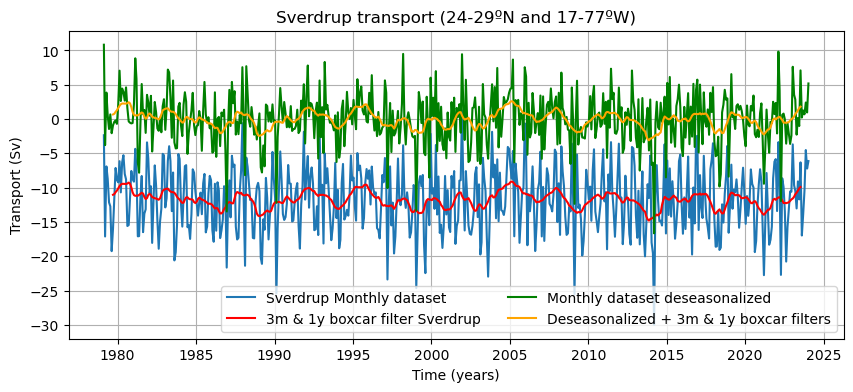

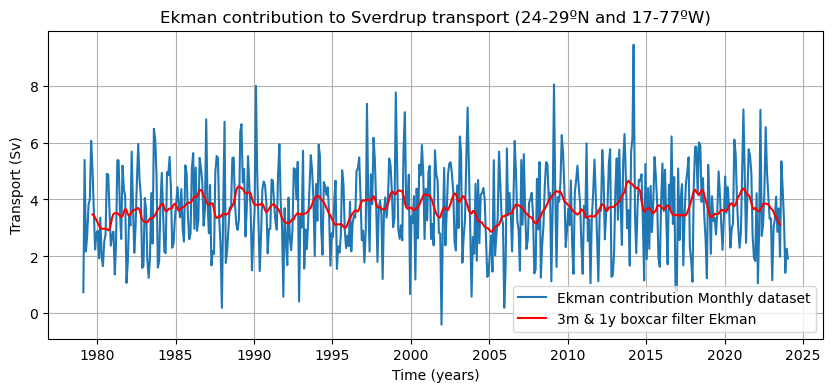

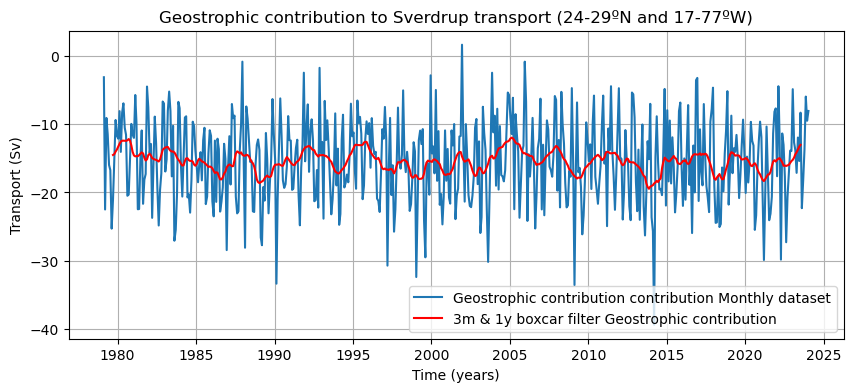

In [30]:
# Average over latitude
V_sv_time = V_sv.sum(dim='longitude')/1e9  # Final Sverdrup transport as a function of time
V_ek_time = V_ek.sum(dim='longitude')/1e3 #Final Ekaman contribution to Sverdrup transport
V_g_time = V_g.sum(dim='longitude') #Final Geostrophic contribution to Sverdrup Transport

# Compute and remove seasonal cycle
def remove_seasonal_cycle(region):
    # Group by month and compute the climatological mean for each month
    climatology = region.groupby('time.month').mean(dim='time')
    # Group by month again and subtract the climatology to remove the seasonal cycle
    deseasonalized = region.groupby('time.month') - climatology
    return deseasonalized

# Compute and remove the seasonal cycle for each region
sverdrup_no_season = remove_seasonal_cycle(V_sv_time)
#ekman_no_season = remove_seasonal_cycle(V_ek_time)
#geostrophy_no_season = remove_seasonal_cycle(V_g_time)

# Apply a rolling boxcar filter (3-month window)
def apply_boxcar_filter(data, window_size):
    return data.rolling(time=window_size, center=True).mean()

# Apply 3-month boxcar filter
full_region_3mo_sverdrup = apply_boxcar_filter(V_sv_time, 3)
full_region_3mo_ekman = apply_boxcar_filter(V_ek_time, 3)
full_region_3mo_geostrophy = apply_boxcar_filter(V_g_time, 3)

sverdrup_no_season_3mo=apply_boxcar_filter(sverdrup_no_season, 3)

# Apply 1-year boxcar filter (12-month window)
full_region_1yr_sverdrup = apply_boxcar_filter(full_region_3mo_sverdrup, 12)
full_region_1yr_ekman = apply_boxcar_filter(full_region_3mo_ekman, 12)
full_region_1yr_geostrophy = apply_boxcar_filter(full_region_3mo_geostrophy, 12)

sverdrup_1yr = apply_boxcar_filter(sverdrup_no_season_3mo, 12)

plt.figure(figsize=(10, 4))
plt.plot(V_sv_time.time,V_sv_time,label='Sverdrup Monthly dataset')
plt.plot(full_region_1yr_sverdrup.time, full_region_1yr_sverdrup,color='red',label='3m & 1y boxcar filter Sverdrup')
plt.plot(sverdrup_no_season.time,sverdrup_no_season,color='green',label='Monthly dataset deseasonalized')
plt.plot(sverdrup_1yr.time, sverdrup_1yr,color='orange',label='Deseasonalized + 3m & 1y boxcar filters')
plt.grid(True)
plt.legend(loc='lower right',fontsize=10,ncol=2)
plt.title('Sverdrup transport (24-29ºN and 17-77ºW)')
plt.ylabel('Transport (Sv)')
plt.xlabel('Time (years)')
V_sv_time.mean(dim='time')

plt.figure(figsize=(10, 4))
plt.plot(V_ek_time.time,V_ek_time,label='Ekman contribution Monthly dataset')
plt.plot(full_region_1yr_ekman.time, full_region_1yr_ekman,color='red',label='3m & 1y boxcar filter Ekman')
plt.grid(True)
plt.legend(loc='lower right',fontsize=10,ncol=1)
plt.title('Ekman contribution to Sverdrup transport (24-29ºN and 17-77ºW)')
plt.ylabel('Transport (Sv)')
plt.xlabel('Time (years)')
V_sv_time.mean(dim='time')

plt.figure(figsize=(10, 4))
plt.plot(V_g_time.time,V_g_time,label='Geostrophic contribution contribution Monthly dataset')
plt.plot(full_region_1yr_geostrophy.time, full_region_1yr_geostrophy,color='red',label='3m & 1y boxcar filter Geostrophic contribution')
plt.grid(True)
plt.legend(loc='lower right',fontsize=10,ncol=1)
plt.title('Geostrophic contribution to Sverdrup transport (24-29ºN and 17-77ºW)')
plt.ylabel('Transport (Sv)')
plt.xlabel('Time (years)')
V_sv_time.mean(dim='time')

# Create a new xarray.Dataset with the necessary variables for new plots
ds = xr.Dataset({
    'V_sv_time': V_sv_time.time,
    'V_sv': V_sv_time,
    'V_sv_3m1y_filter_time': full_region_1yr_sverdrup.time,'V_sv_3m1y_filter': full_region_1yr_sverdrup,
    'sverdrup_no_season_time': sverdrup_no_season.time,'sverdrup_no_season': sverdrup_no_season,
    'sverdrup_no_season_3m1y_filter_time': sverdrup_1yr.time,'sverdrup_no_season_3m1y_filter': sverdrup_1yr,
    'V_g_time': V_g_time.time,
    'V_g': V_g_time, 
    'V_ek_time': V_ek_time.time,
    'V_ek':V_ek_time
})

# Save the dataset to a NetCDF file
#ds.to_netcdf('/Users/cristinaarumiplanas/Documents/Papers_Cristina/University_Hamburg/Sverdrup/Data/Winds/sverdrup_ek_g_transport.nc')

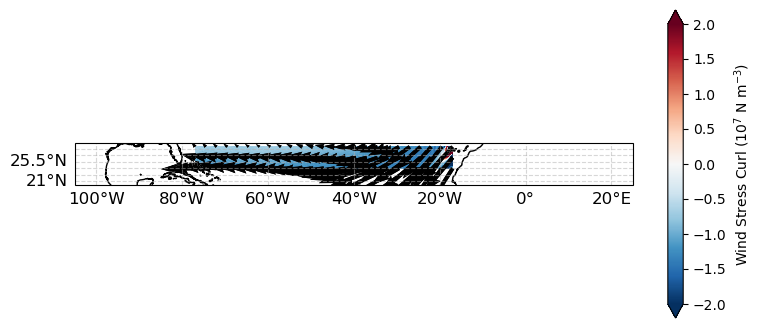

In [31]:
def quick_quiver(u, v, sampling_x=10, sampling_y=10, scalar=None, mag_max=None, **kwargs):
    x = u.longitude
    y = u.latitude
    slx = slice(None, None, sampling_x)
    sly = slice(None, None, sampling_y)
    sl2d = (sly, slx)
    if scalar is None:
        mag = 0.5 * (u**2 + v**2)**0.5
    else:
        mag = scalar

    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, **kwargs)
    ax.set_extent([-105, 25, 20, 30], crs=ccrs.PlateCarree())  # Set the extent of the map
    land = cfeature.NaturalEarthFeature('physical', 'land', '50m',edgecolor='face',facecolor='white')
    ax.add_feature(land)
    ax.coastlines()
    
    # Add gridlines
    gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 12}
    gl.ylabel_style = {'size': 12}

    # Plot the scalar field under the land
    cbar = mag.plot(ax=ax, vmax=2, transform=ccrs.PlateCarree(), zorder=1, cbar_kwargs={'label': 'Wind Stress Curl (10$^{7}$ N m$^{-3}$)'})  
    ax.quiver(x[slx], y[sly], u[sl2d], v[sl2d], transform=ccrs.PlateCarree(), zorder=1)
    
    return fig, ax, ax.quiver(x[slx], y[sly], u[sl2d], v[sl2d], transform=ccrs.PlateCarree(), zorder=1)

# Represento el mapa con los vientos:
fig, ax, quiv = quick_quiver(tau_x.mean(dim='time'), tau_y.mean(dim='time'), scalar=curl_tau.mean(dim='time'), mag_max=2, sampling_x=10, figsize=(9, 4))

# Guardar la figura en un archivo PDF
#fig.savefig('figura_vientos.pdf')

In [34]:
# Subset into the three longitude regions
full_region = curl_tau_lat_avg.sel(longitude=slice(-77, -17)).mean(dim='longitude')
region_1 = curl_tau_lat_avg.sel(longitude=slice(-77, -57)).mean(dim='longitude')
region_2 = curl_tau_lat_avg.sel(longitude=slice(-57, -37)).mean(dim='longitude')
region_3 = curl_tau_lat_avg.sel(longitude=slice(-37, -17)).mean(dim='longitude')


In [35]:
# Compute and remove seasonal cycle
def remove_seasonal_cycle(region):
    # Group by month and compute the climatological mean for each month
    climatology = region.groupby('time.month').mean(dim='time')
    
    # Group by month again and subtract the climatology to remove the seasonal cycle
    deseasonalized = region.groupby('time.month') - climatology
    
    return deseasonalized

# Compute and remove the seasonal cycle for each region
full_region_deseasonalized = remove_seasonal_cycle(full_region)
region_1_deseasonalized = remove_seasonal_cycle(region_1)
region_2_deseasonalized = remove_seasonal_cycle(region_2)
region_3_deseasonalized = remove_seasonal_cycle(region_3)

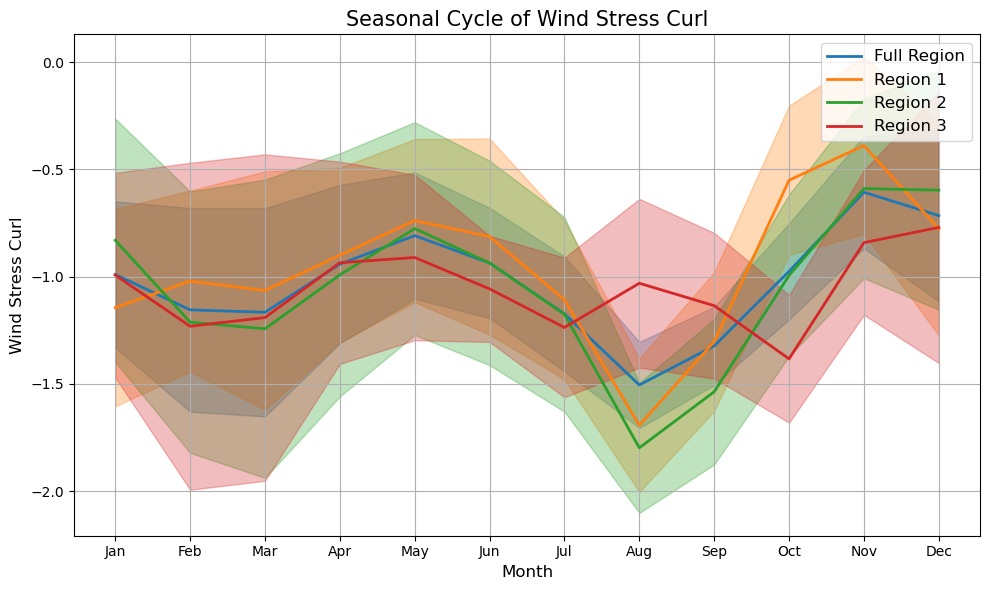

In [36]:
def compute_seasonal_cycle(region):
    # Group by month and compute the climatological mean and std for each month
    climatology = region.groupby('time.month').mean(dim='time')
    climatology_std = region.groupby('time.month').std(dim='time')
    
    return climatology, climatology_std

# Compute the seasonal cycle for each region
full_region_cycle, full_region_std = compute_seasonal_cycle(full_region)
region_1_cycle, region_1_std = compute_seasonal_cycle(region_1)
region_2_cycle, region_2_std = compute_seasonal_cycle(region_2)
region_3_cycle, region_3_std = compute_seasonal_cycle(region_3)


months = np.arange(1, 13)
fig, ax = plt.subplots(figsize=(10, 6))  # Create a single plot

# Plotting function
def plot_seasonal_cycle(ax, months, seasonal_cycle, seasonal_std, label, color):
    ax.plot(months, seasonal_cycle, color=color, linewidth=2, label=label)
    ax.fill_between(months, seasonal_cycle - seasonal_std, seasonal_cycle + seasonal_std, color=color, alpha=0.3)

# Plot for each region on the same plot
plot_seasonal_cycle(ax, months, full_region_cycle, full_region_std, 'Full Region', 'C0')
plot_seasonal_cycle(ax, months, region_1_cycle, region_1_std, 'Region 1', 'C1')
plot_seasonal_cycle(ax, months, region_2_cycle, region_2_std, 'Region 2', 'C2')
plot_seasonal_cycle(ax, months, region_3_cycle, region_3_std, 'Region 3', 'C3')
ax.set_xticks(np.arange(1, 13))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.grid(True)
ax.set_title('Seasonal Cycle of Wind Stress Curl', fontsize=15)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Wind Stress Curl', fontsize=12)
ax.legend(loc='best', fontsize=12)
plt.tight_layout()
plt.show()

In [37]:
# Apply a rolling boxcar filter (3-month window)
def apply_boxcar_filter(data, window_size):
    return data.rolling(time=window_size, center=True).mean()

# Apply 3-month boxcar filter
full_region_3mo_filtered = apply_boxcar_filter(full_region_deseasonalized, 3)
region_1_3mo_filtered = apply_boxcar_filter(region_1_deseasonalized, 3)
region_2_3mo_filtered = apply_boxcar_filter(region_2_deseasonalized, 3)
region_3_3mo_filtered = apply_boxcar_filter(region_3_deseasonalized, 3)

# Apply 1-year boxcar filter (12-month window)
full_region_1yr_filtered = apply_boxcar_filter(full_region_3mo_filtered, 12)
region_1_1yr_filtered = apply_boxcar_filter(region_1_3mo_filtered, 12)
region_2_1yr_filtered = apply_boxcar_filter(region_2_3mo_filtered, 12)
region_3_1yr_filtered = apply_boxcar_filter(region_3_3mo_filtered, 12)


In [38]:
#Convert datetime64 to decimal years in order to plot both datasets in one plot
def datetime64_to_year_fraction(dates):
    dates = pd.to_datetime(dates.values)  # Convert Xarray datetime64 to pandas datetime
    year_start = dates.year
    start_of_year = pd.to_datetime([f'{y}-01-01' for y in year_start])
    next_year = pd.to_datetime([f'{y+1}-01-01' for y in year_start])
    year_fraction = year_start + (dates - start_of_year).days / (next_year - start_of_year).days
    return year_fraction

# Convert time in the second dataset from datetime64 to decimal years
full_region_time_years = datetime64_to_year_fraction(full_region.time.time)
region_1_time_years = datetime64_to_year_fraction(region_1.time)
region_2_time_years = datetime64_to_year_fraction(region_2.time)
region_3_time_years = datetime64_to_year_fraction(region_3.time)

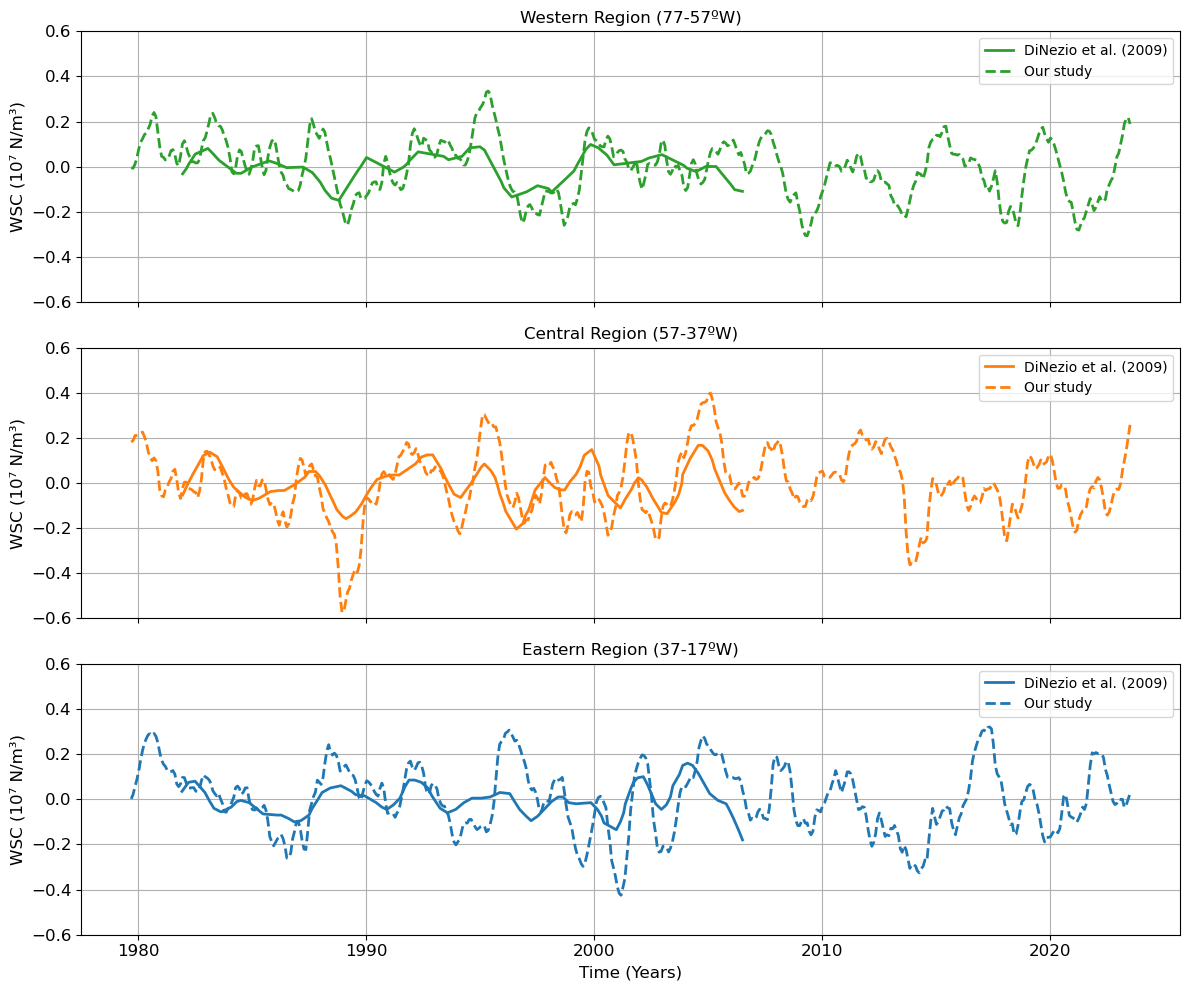

In [39]:
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Plot for Western Region
#axes[0].axhline(y=0, color='black', linestyle='--', linewidth=1.5)
axes[0].plot(time_west, wind_west, color='C2', linewidth=2, label='DiNezio et al. (2009)')
axes[0].plot(region_1_time_years, region_1_1yr_filtered, color='C2', linestyle='--', linewidth=2, label='Our study')
axes[0].set_ylabel('WSC (10⁷ N/m³)', fontsize=12)
axes[0].legend(loc='upper right', fontsize=10)
axes[0].grid(True)
axes[0].tick_params(axis='both', which='major', labelsize=12)
axes[0].set_ylim([-0.6, 0.6])
axes[0].set_title('Western Region (77-57ºW)')

# Plot for Central Region
#axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1.5)
axes[1].plot(time_central, wind_central, color='C1', linewidth=2, label='DiNezio et al. (2009)')
axes[1].plot(region_2_time_years, region_2_1yr_filtered, color='C1', linestyle='--', linewidth=2, label='Our study')
axes[1].set_ylabel('WSC (10⁷ N/m³)', fontsize=12)
axes[1].legend(loc='upper right', fontsize=10)
axes[1].grid(True)
axes[1].tick_params(axis='both', which='major', labelsize=12)
axes[1].set_ylim([-0.6, 0.6])
axes[1].set_title('Central Region (57-37ºW)')

# Plot for Eastern Region
#axes[2].axhline(y=0, color='black', linestyle='--', linewidth=1.5)
axes[2].plot(time_east, wind_east, color='C0', linewidth=2, label='DiNezio et al. (2009)')
axes[2].plot(region_3_time_years, region_3_1yr_filtered, color='C0', linestyle='--', linewidth=2, label='Our study')
axes[2].set_xlabel('Time (Years)', fontsize=12)
axes[2].set_ylabel('WSC (10⁷ N/m³)', fontsize=12)
axes[2].legend(loc='upper right', fontsize=10)
axes[2].grid(True)
axes[2].tick_params(axis='both', which='major', labelsize=12)
axes[2].set_ylim([-0.6, 0.6])
axes[2].set_title('Eastern Region (37-17ºW)')

plt.tight_layout()
plt.show()

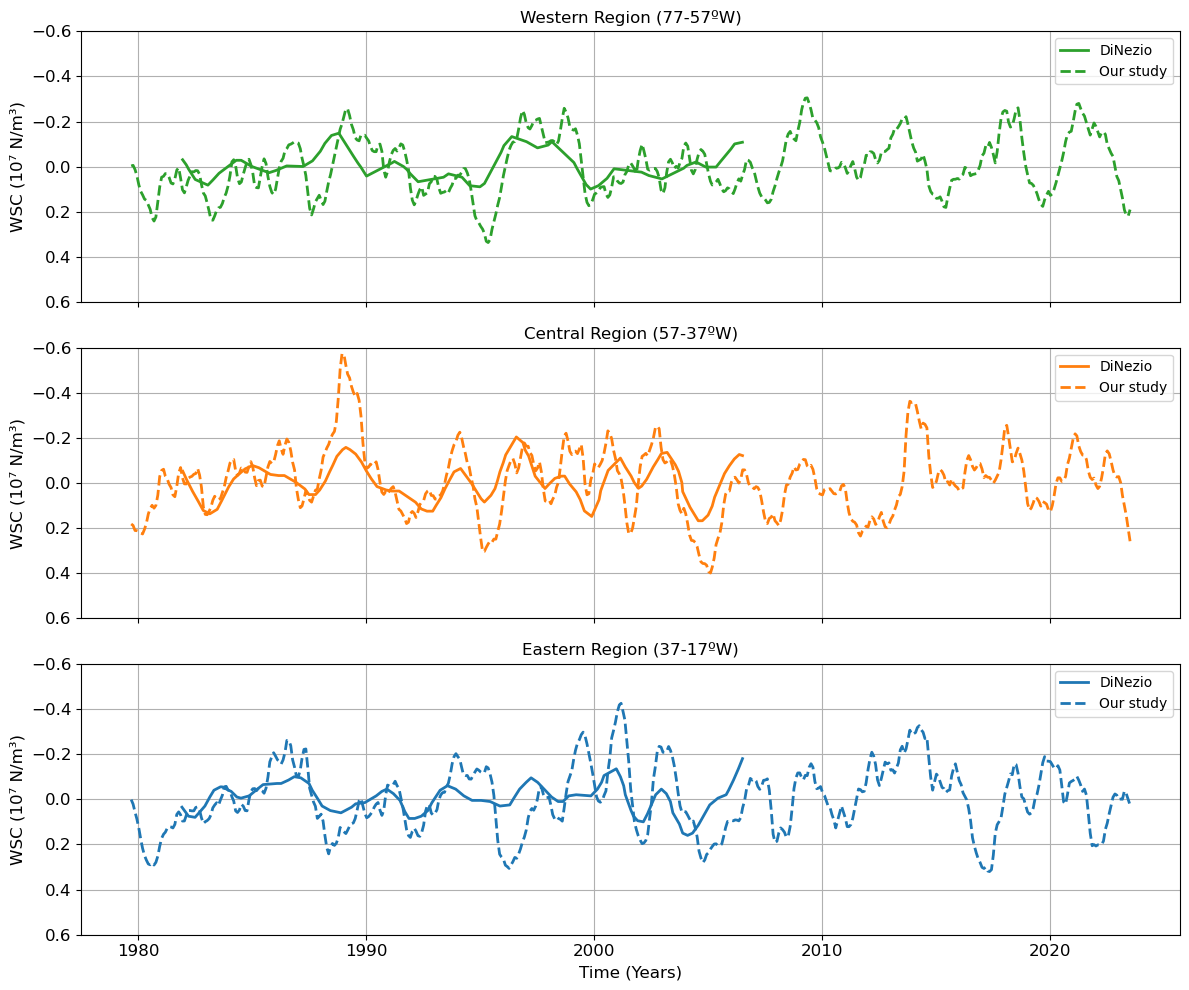

In [40]:
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Plot for Western Region
axes[0].plot(time_west, wind_west, color='C2', linewidth=2, label='DiNezio')
axes[0].plot(region_1_time_years, region_1_1yr_filtered, color='C2', linestyle='--', linewidth=2, label='Our study')
axes[0].set_ylabel('WSC (10⁷ N/m³)', fontsize=12)
axes[0].legend(loc='upper right', fontsize=10)
axes[0].grid(True)
axes[0].tick_params(axis='both', which='major', labelsize=12)
axes[0].set_ylim([-0.6, 0.6])
axes[0].invert_yaxis()  # Invert Y-axis
axes[0].set_title('Western Region (77-57ºW)')

# Plot for Central Region
axes[1].plot(time_central, wind_central, color='C1', linewidth=2, label='DiNezio')
axes[1].plot(region_2_time_years, region_2_1yr_filtered, color='C1', linestyle='--', linewidth=2, label='Our study')
axes[1].set_ylabel('WSC (10⁷ N/m³)', fontsize=12)
axes[1].legend(loc='upper right', fontsize=10)
axes[1].grid(True)
axes[1].tick_params(axis='both', which='major', labelsize=12)
axes[1].set_ylim([-0.6, 0.6])
axes[1].invert_yaxis()  # Invert Y-axis
axes[1].set_title('Central Region (57-37ºW)')

# Plot for Eastern Region
axes[2].plot(time_east, wind_east, color='C0', linewidth=2, label='DiNezio')
axes[2].plot(region_3_time_years, region_3_1yr_filtered, color='C0', linestyle='--', linewidth=2, label='Our study')
axes[2].set_xlabel('Time (Years)', fontsize=12)
axes[2].set_ylabel('WSC (10⁷ N/m³)', fontsize=12)
axes[2].legend(loc='upper right', fontsize=10)
axes[2].grid(True)
axes[2].tick_params(axis='both', which='major', labelsize=12)
axes[2].set_ylim([-0.6, 0.6])
axes[2].invert_yaxis()  # Invert Y-axis
axes[2].set_title('Eastern Region (37-17ºW)')

plt.tight_layout()
plt.show()


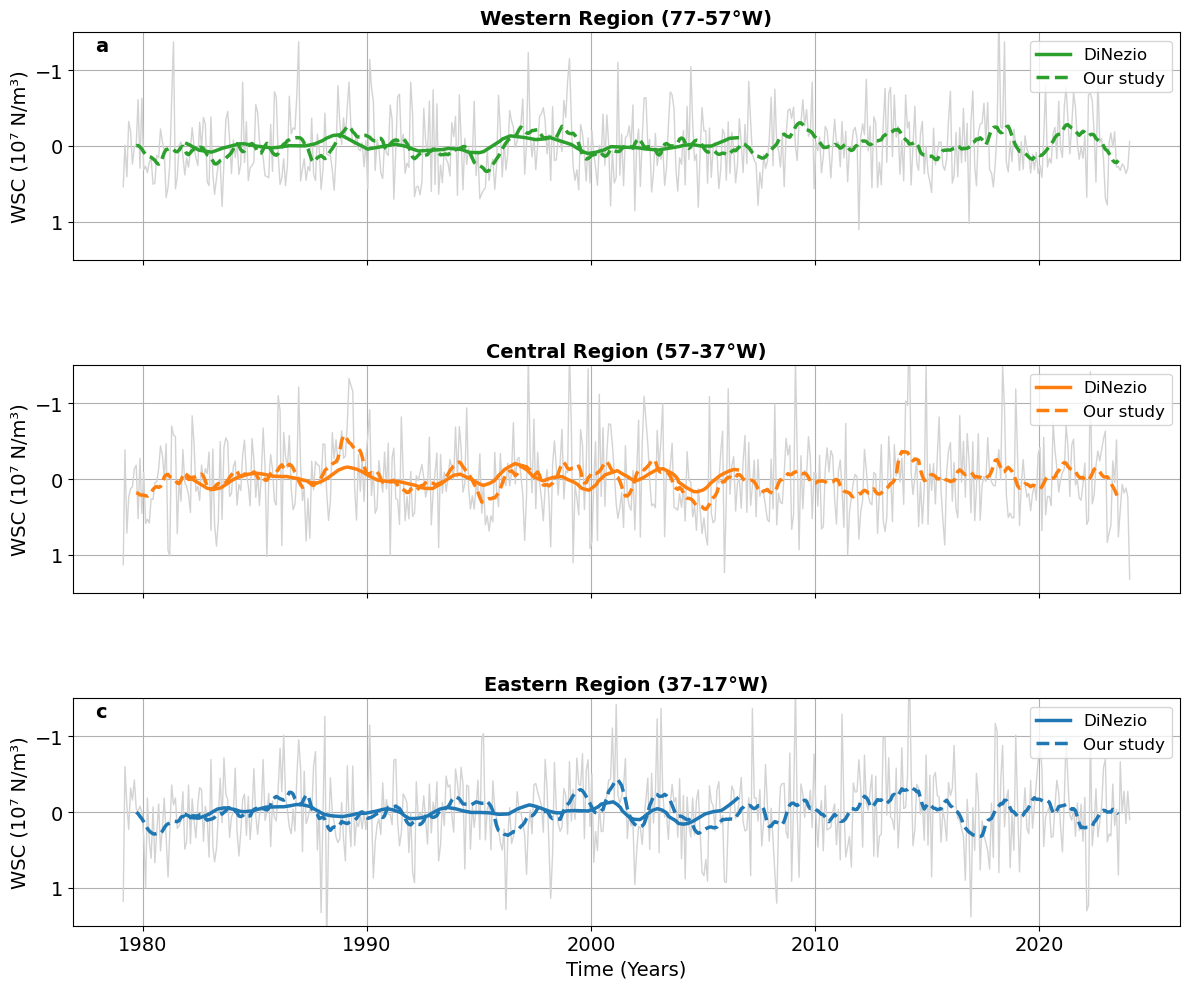

In [41]:
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Plot for Western Region (a)
axes[0].plot(region_1_time_years, region_1_deseasonalized, color='lightgrey', linewidth=1)
axes[0].plot(time_west, wind_west, color='C2', linewidth=2.5, label='DiNezio')
axes[0].plot(region_1_time_years, region_1_1yr_filtered, color='C2', linestyle='--', linewidth=2.5, label='Our study')
axes[0].set_ylabel('WSC (10⁷ N/m³)', fontsize=14)
axes[0].legend(loc='upper right', fontsize=12)
axes[0].grid(True)
axes[0].tick_params(axis='both', which='major', labelsize=14)
axes[0].set_ylim([-1.5, 1.5])
axes[0].set_title('Western Region (77-57\u00B0W)', fontsize=14, fontweight='bold')
axes[0].text(0.02, 0.92, 'a', transform=axes[0].transAxes, fontsize=14, fontweight='bold')
axes[0].invert_yaxis()
# Plot for Central Region (b)
axes[1].plot(region_2_time_years, region_2_deseasonalized, color='lightgrey', linewidth=1)
axes[1].plot(time_central, wind_central, color='C1', linewidth=2.5, label='DiNezio')
axes[1].plot(region_2_time_years, region_2_1yr_filtered, color='C1', linestyle='--', linewidth=2.5, label='Our study')
axes[1].set_ylabel('WSC (10⁷ N/m³)', fontsize=14)
axes[1].legend(loc='upper right', fontsize=12)
axes[1].grid(True)
axes[1].tick_params(axis='both', which='major', labelsize=14)
axes[1].set_ylim([-1.5, 1.5])
axes[1].set_title('Central Region (57-37\u00B0W)', fontsize=14, fontweight='bold')
axes[1].text(0.02, 0.92, 'b', transform=axes[2].transAxes, fontsize=14, fontweight='bold')
axes[1].invert_yaxis()
# Plot for Eastern Region (c)
axes[2].plot(region_3_time_years, region_3_deseasonalized, color='lightgrey', linewidth=1)
axes[2].plot(time_east, wind_east, color='C0', linewidth=2.5, label='DiNezio')
axes[2].plot(region_3_time_years, region_3_1yr_filtered, color='C0', linestyle='--', linewidth=2.5, label='Our study')
axes[2].set_xlabel('Time (Years)', fontsize=14)
axes[2].set_ylabel('WSC (10⁷ N/m³)', fontsize=14)
axes[2].legend(loc='upper right', fontsize=12)
axes[2].grid(True)
axes[2].tick_params(axis='both', which='major', labelsize=14)
axes[2].set_ylim([-1.5, 1.5])
axes[2].set_title('Eastern Region (37-17\u00B0W)', fontsize=14, fontweight='bold')
axes[2].text(0.02, 0.92, 'c', transform=axes[2].transAxes, fontsize=14, fontweight='bold')
axes[2].invert_yaxis()
# Plot for Full Region (d)
#axes[0].plot(full_region_time_years, full_region_deseasonalized, color='lightgrey', linewidth=1)
#axes[0].plot(full_region_time_years, full_region_1yr_filtered, color='C6', linestyle='--', linewidth=2.5, label='Our study')
#axes[0].set_xlabel('Time (Years)', fontsize=14)
#axes[0].set_ylabel('WSC (10⁷ N/m³)', fontsize=14)
#axes[3].legend(loc='upper right', fontsize=12)
#axes[0].grid(True)
#axes[0].tick_params(axis='both', which='major', labelsize=14)
#axes[0].set_ylim([-1.5, 1.5])
#axes[0].set_title('Full Region (77-17\u00B0W)', fontsize=16, fontweight='bold')
#axes[0].text(0.02, 0.92, 'a', transform=axes[0].transAxes, fontsize=14, fontweight='bold')
#axes[0].invert_yaxis()
plt.tight_layout()
plt.show()

#\u00B0 is the degree symbol

In [25]:
# Create a new xarray.Dataset with the necessary variables for new plots
ds = xr.Dataset({
    'full_region': full_region,
    'full_region_deseasonalized': full_region_deseasonalized,
    'full_region_1yr_filtered': full_region_1yr_filtered,
    'region_1_time_years':region_1_time_years, 'region_2_time_years':region_2_time_years,
    'region_3_time_years':region_3_time_years,'region_1_deseasonalized':region_1_deseasonalized,
    'region_2_deseasonalized':region_2_deseasonalized,'region_3_deseasonalized':region_3_deseasonalized,

})

# Save the dataset to a NetCDF file
#ds.to_netcdf('/Users/cristinaarumiplanas/Documents/Papers_Cristina/University_Hamburg/Sverdrup/Data/Winds/all_regions_WSC.nc')

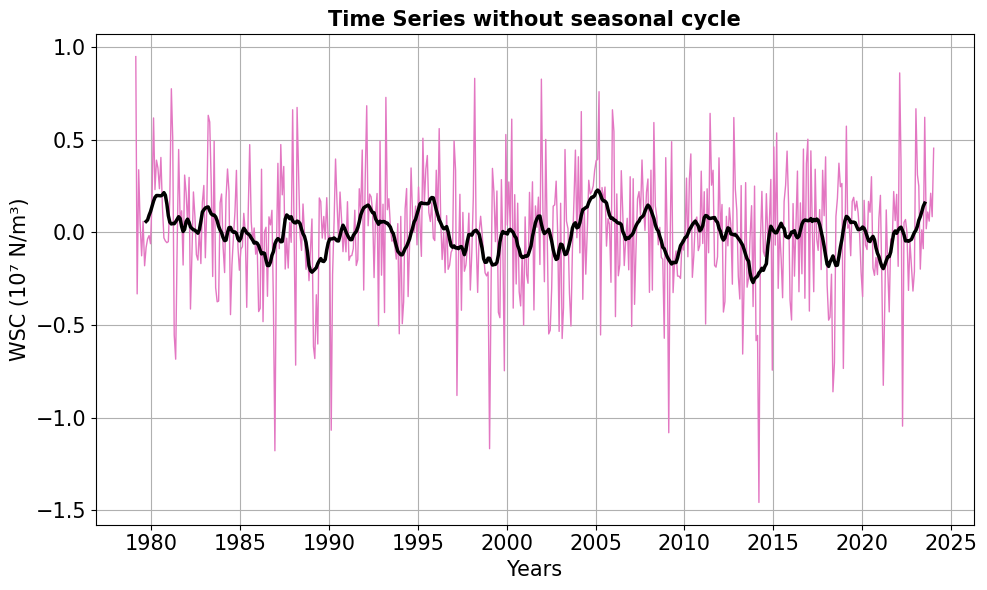

In [42]:
# Plotting the time series
plt.figure(figsize=(10, 6))
plt.plot(full_region.time, full_region_deseasonalized, color='C6', linewidth=1)
plt.plot(full_region.time, full_region_1yr_filtered, color='k', linewidth=2.5)
plt.xlabel('Years', fontsize=15)
plt.ylabel('WSC (10⁷ N/m³)', fontsize=15)
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.title('Time Series without seasonal cycle', fontsize=15, fontweight='bold')
fig.autofmt_xdate() #rotate xlabels
plt.tight_layout()
plt.show()


In [44]:
#compute the wind stress curl daily
# Magnitude of wind speed in m/s
wind_speed2 = np.sqrt(u10_daily.u10**2+v10_daily.v10**2)
#print(wind_speed)

# Compute wind stress components (tau_x, tau_y) in N m-2 (or in Pa)
tau_x2=rho_air*Cd*u10_daily.u10*wind_speed2 # Zonal wind stress
tau_y2=rho_air*Cd*v10_daily.v10*wind_speed2 # Meridional wind stress

# Derivatives of the wind stress components with respect to lon and lat
d_tau_y_dx2=tau_y2.differentiate('longitude')
d_tau_x_dy2=tau_x2.differentiate('latitude')

# Wind stress curl calculation N m-3
curl_tau2=(d_tau_y_dx2-d_tau_x_dy2)/(R*np.cos(np.deg2rad(u10_daily.latitude)))
curl_tau2=curl_tau2*1e9

# Average over all latitudes 29N-24N
curl_tau_lat_avg2 = curl_tau2.mean(dim='latitude')

In [45]:
#Remove seasonality of the dataset
daily_climatology = curl_tau_lat_avg2.groupby('time.dayofyear').mean(dim=['time'])#if you want one value for each longitude you should include 'longitude' next to time
curl_tau_daily_no_season = curl_tau_lat_avg2.groupby('time.dayofyear') - daily_climatology

In [46]:
# Define the number of days for the boxcar filters
days_in_3_months = 3 * 30  # Approx 3 months in days
days_in_1_year = 365  # Approx 1 year in days

# Apply the 3-month and 1-year boxcar filters with adjusted rolling window parameters
curl_tau_filtered_3month = curl_tau_daily_no_season.rolling(time=days_in_3_months, center=True, min_periods=1).mean()
curl_tau_filtered_1year = curl_tau_daily_no_season.rolling(time=days_in_1_year, center=True, min_periods=1).mean()
curl_tau_filtered_3m_1year = curl_tau_filtered_3month.rolling(time=days_in_1_year, center=True, min_periods=1).mean()

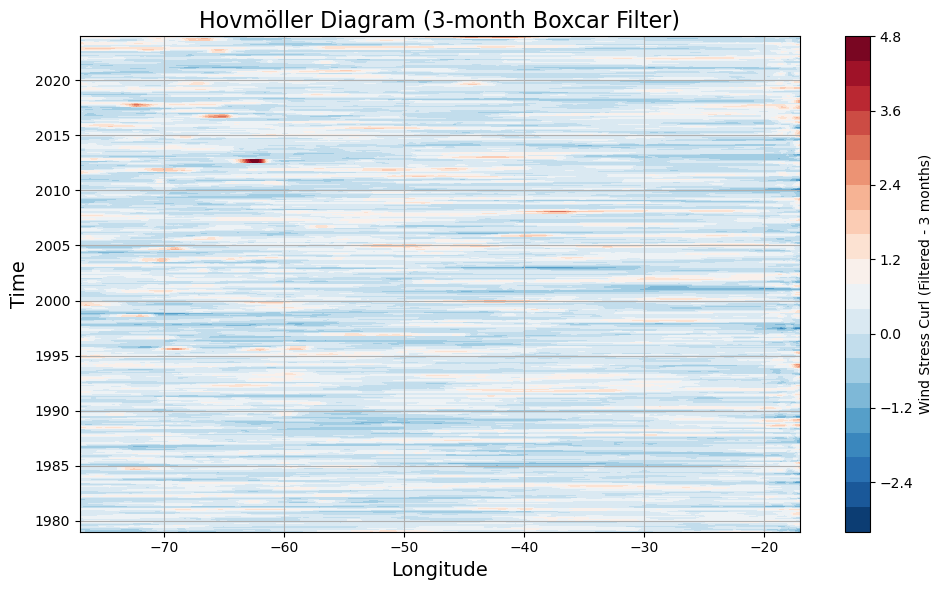

In [47]:
# Plot the Hovmöller diagram for the 3-month filtered data
plt.figure(figsize=(10, 6))
plt.contourf(curl_tau_filtered_3month.longitude, curl_tau_filtered_3month.time, curl_tau_filtered_3month, cmap='RdBu_r', levels=20)
plt.colorbar(label='Wind Stress Curl (Filtered - 3 months)')

plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Time', fontsize=14)
plt.title('Hovmöller Diagram (3-month Boxcar Filter)', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

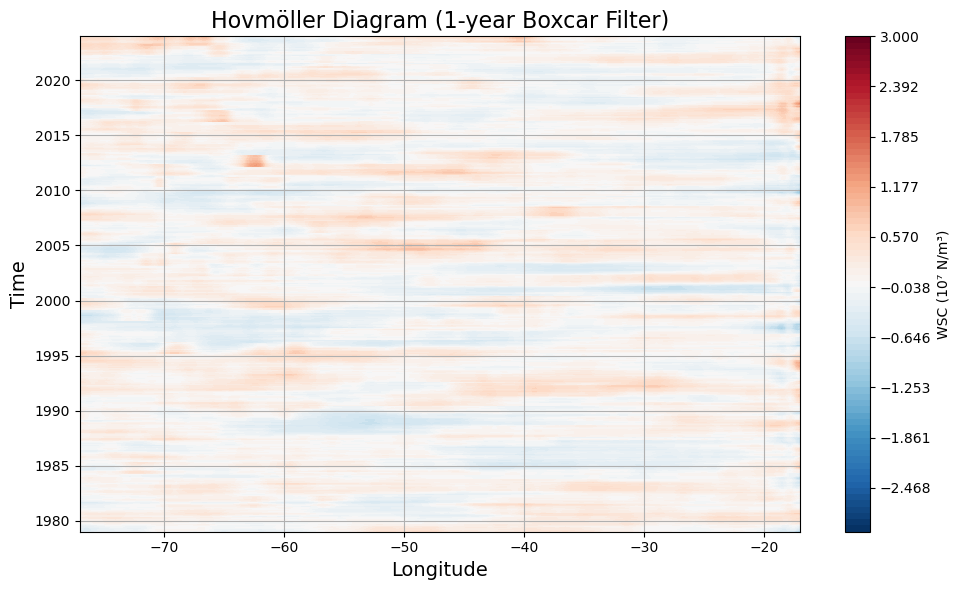

In [48]:
# Plot the Hovmöller diagram for the 1-year filtered data
plt.figure(figsize=(10, 6))
levels = np.linspace(-3,3, 80)  # 21 levels from -2 to 2

plt.contourf(curl_tau_filtered_1year.longitude, curl_tau_filtered_1year.time, curl_tau_filtered_1year, 
             cmap='RdBu_r', levels=levels)
plt.colorbar(label='WSC (10⁷ N/m³)')

plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Time', fontsize=14)
plt.title('Hovmöller Diagram (1-year Boxcar Filter)', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()


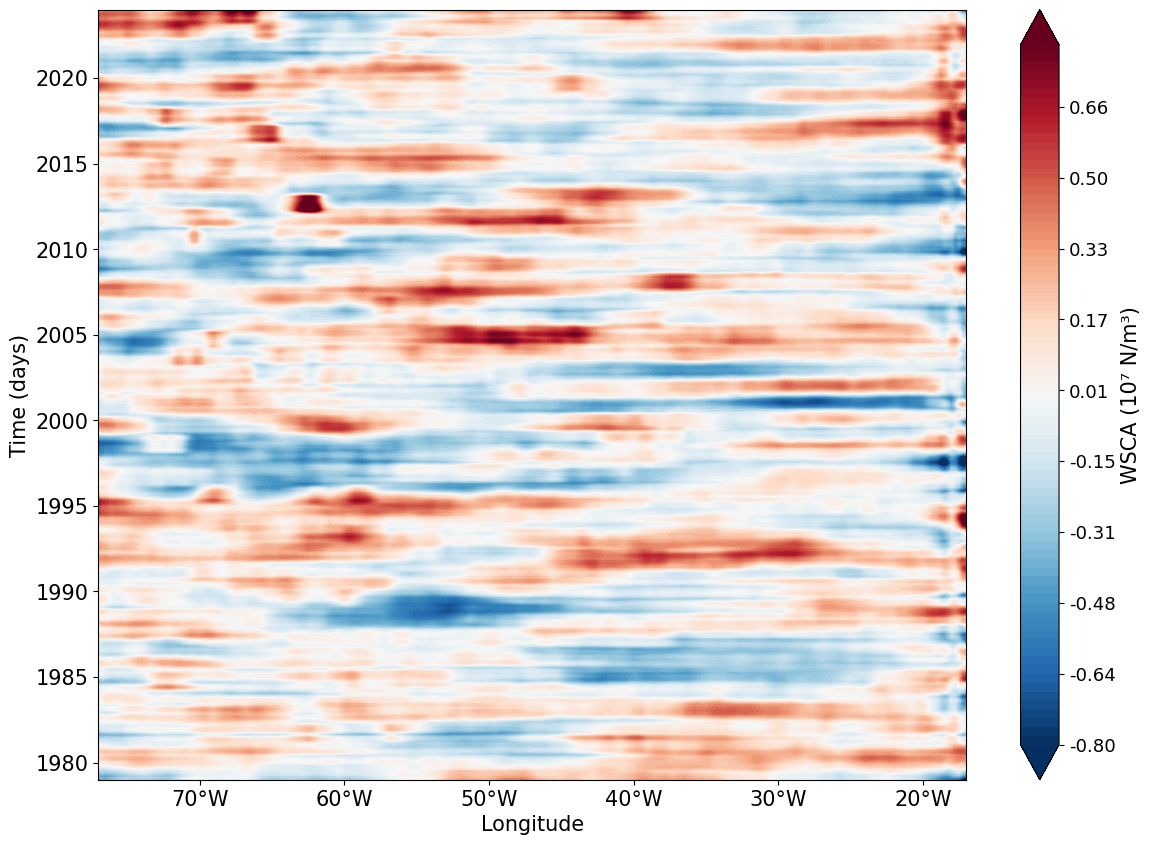

In [49]:
from matplotlib.ticker import FuncFormatter, FormatStrFormatter

def format_longitude(value, pos):
    return f'{int(abs(value))}°W' 

# Plot the Hovmöller diagram for the 1-year filtered data
fig, ax = plt.subplots(figsize=(14, 10))
cmap = plt.get_cmap('RdBu_r')
levels = np.linspace(-0.8, 0.8, 80)
contour = ax.contourf(curl_tau_filtered_3m_1year.longitude, 
                      curl_tau_filtered_3m_1year.time, curl_tau_filtered_3m_1year, 
                      levels=levels, cmap=cmap, extend='both')
cbar = plt.colorbar(contour, ax=ax, orientation='vertical')
cbar.ax.tick_params(labelsize=13)
cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.xaxis.set_major_formatter(FuncFormatter(format_longitude))
cbar.set_label('WSCA (10⁷ N/m³)', fontsize=15)
ax.set_xlabel('Longitude', fontsize=15)
ax.set_ylabel('Time (days)', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [51]:
# SSHA
file_path='/Users/cristinaarumiplanas/Documents/Papers_Cristina/University_Hamburg/Sverdrup/Data/SSH/sla/cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_1720009044284.nc'
ds=xr.open_dataset(file_path)
ssh=ds['sla']#adt sla
lat_values=ds['latitude']

# Compute the latitudinal average between 29ºN and 24ºN 
ssh_avg=ssh.mean(dim='latitude')

# Compute mean SSH over time for the latitudinally averaged data
mean_ssh=ssh_avg.mean(dim='time')

# Compute SSHA 
ssha=ssh_avg-mean_ssh

In [52]:
# Remove global mean sea level rise (about 21 cm) from SSHA
gmsl_file_path='/Users/cristinaarumiplanas/Documents/Papers_Cristina/University_Hamburg/Sverdrup/Data/GlobalMeanSL_Rise/omi_climate_sl_global_area_averaged_anomalies_19930101_P20240228.nc'
gmsl_ds=xr.open_dataset(gmsl_file_path)
gmsl=gmsl_ds['MSL_filtered_GIA_TPA_corrected_adjusted']
#print(gmsl)
#print(ssha) #they have the same time variable

# Remove GMSL (/100 from cm to m) from the SSHA
ssha_corrected=ssha-gmsl/100

# Compute the zonal mean (mean across all longitudes) at each time step
zonal_mean = ssha_corrected.mean(dim='longitude')

# Subtract the zonal mean from the SSHA to remove the seasonal cycle
ssha_deseasonalized = ssha_corrected - zonal_mean

SSHA time series starts: 1993-01-01T00:00:00.000000000, ends: 2023-06-07T00:00:00.000000000


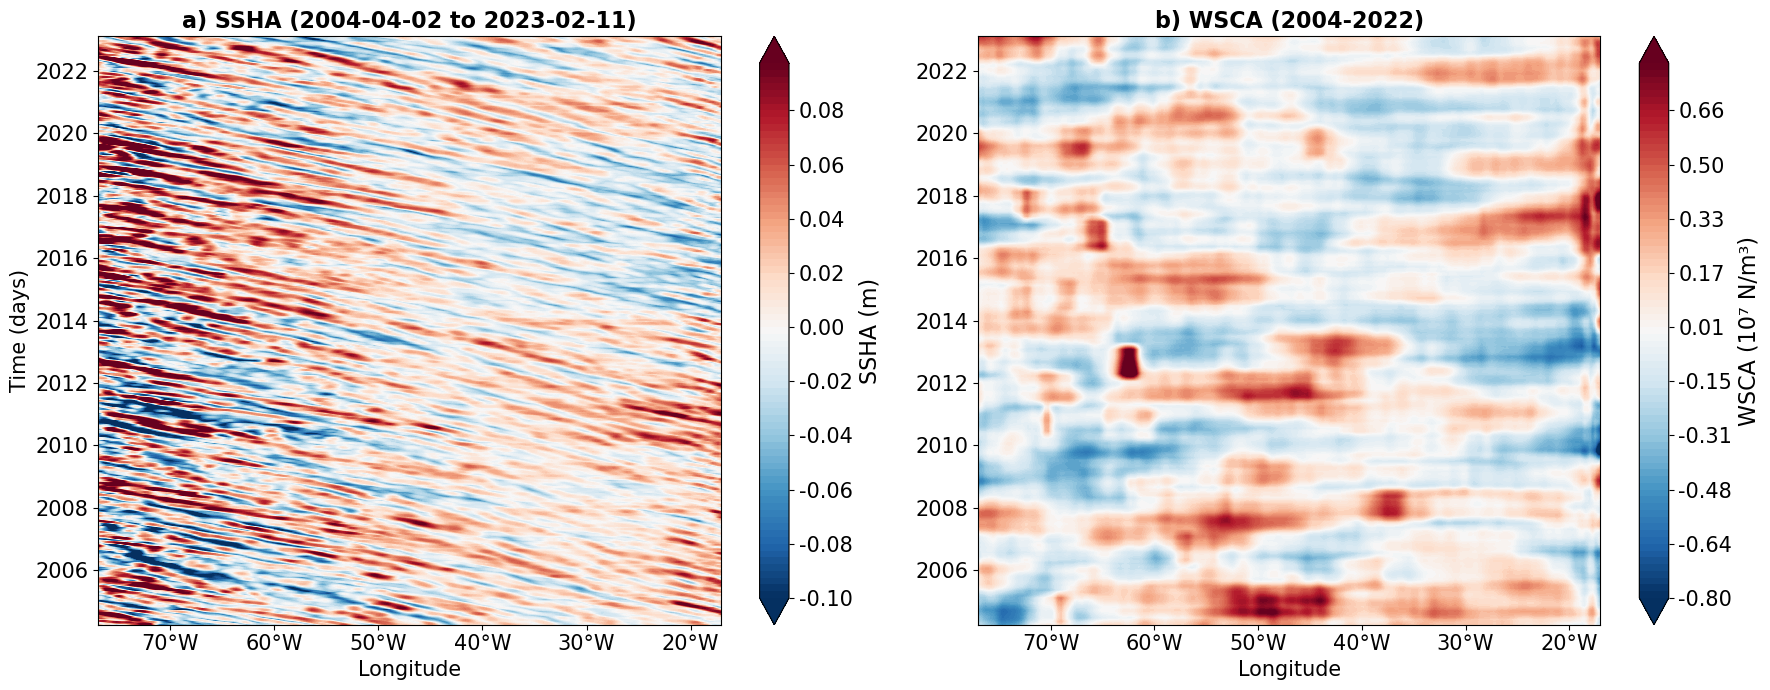

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, FormatStrFormatter

# Define the longitude formatter function for the labels
def format_longitude(value, tick_number):
    degree = int(np.abs(value))
    return f"{degree}°W"

levels_ssha = np.linspace(-0.1, 0.1, 80) 
levels_wsc = np.linspace(-0.8, 0.8, 80) 
cmap_ssha=plt.get_cmap('RdBu_r') 
cmap_wsc=plt.get_cmap('RdBu_r') 
ssha_start_time = ssha_deseasonalized['time'].values[0]
ssha_end_time = ssha_deseasonalized['time'].values[-1]
print(f"SSHA time series starts: {ssha_start_time}, ends: {ssha_end_time}")

# Filter WSCA to match SSHA time series period
wsc_filtered_full_period = curl_tau_filtered_3m_1year.sel(time=slice(ssha_start_time, ssha_end_time))

# Filter SSHA for longitude range -77 to -17
ssha_filtered_longitude = ssha_deseasonalized.sel(longitude=slice(-77, -17))

fig, axs = plt.subplots(1, 2, figsize=(18, 7))

ssha_filtered_2004_2023 = ssha_filtered_longitude.sel(time=slice('2004-04-02 00:00:00', '2023-02-11 00:00:00'))  # Filter SSHA data for 2004 to 2023
contour_ssha_2004_2023 = axs[0].contourf(ssha_filtered_2004_2023['longitude'], 
                                         ssha_filtered_2004_2023['time'].values, 
                                         ssha_filtered_2004_2023.values, 
                                         levels=levels_ssha, cmap=cmap_ssha, extend='both')

cbar_ssha_2004_2023 = plt.colorbar(contour_ssha_2004_2023, ax=axs[0], orientation='vertical')
cbar_ssha_2004_2023.ax.tick_params(labelsize=15)
cbar_ssha_2004_2023.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
cbar_ssha_2004_2023.set_label('SSHA (m)', fontsize=16)  
cbar_ssha_2004_2023.ax.xaxis.set_label_position('top')

axs[0].set_xlabel('Longitude', fontsize=15)
axs[0].set_ylabel('Time (days)', fontsize=15)
axs[0].xaxis.set_major_formatter(FuncFormatter(format_longitude))
axs[0].set_title('a) SSHA (2004-04-02 to 2023-02-11)', fontsize=16, fontweight='bold')
axs[0].tick_params(labelsize=15)

wsc_filtered_2004_2022 = curl_tau_filtered_3m_1year.sel(time=slice('2004-04-02 00:00:00', '2023-02-11 00:00:00'))  # Filter WSC data for 2004 to 2022
contour_wsc_2004_2022 = axs[1].contourf(wsc_filtered_2004_2022.longitude, 
                                        wsc_filtered_2004_2022.time, 
                                        wsc_filtered_2004_2022, 
                                        levels=levels_wsc, cmap=cmap_wsc, extend='both')

cbar_wsc_2004_2022 = plt.colorbar(contour_wsc_2004_2022, ax=axs[1], orientation='vertical')
cbar_wsc_2004_2022.ax.tick_params(labelsize=15)
cbar_wsc_2004_2022.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
cbar_wsc_2004_2022.set_label('WSCA (10⁷ N/m³)', fontsize=16)

axs[1].set_xlabel('Longitude', fontsize=15)
axs[1].xaxis.set_major_formatter(FuncFormatter(format_longitude))
axs[1].set_title('b) WSCA (2004-2022)', fontsize=16, fontweight='bold')
axs[1].tick_params(labelsize=15)
plt.tight_layout()
plt.show()


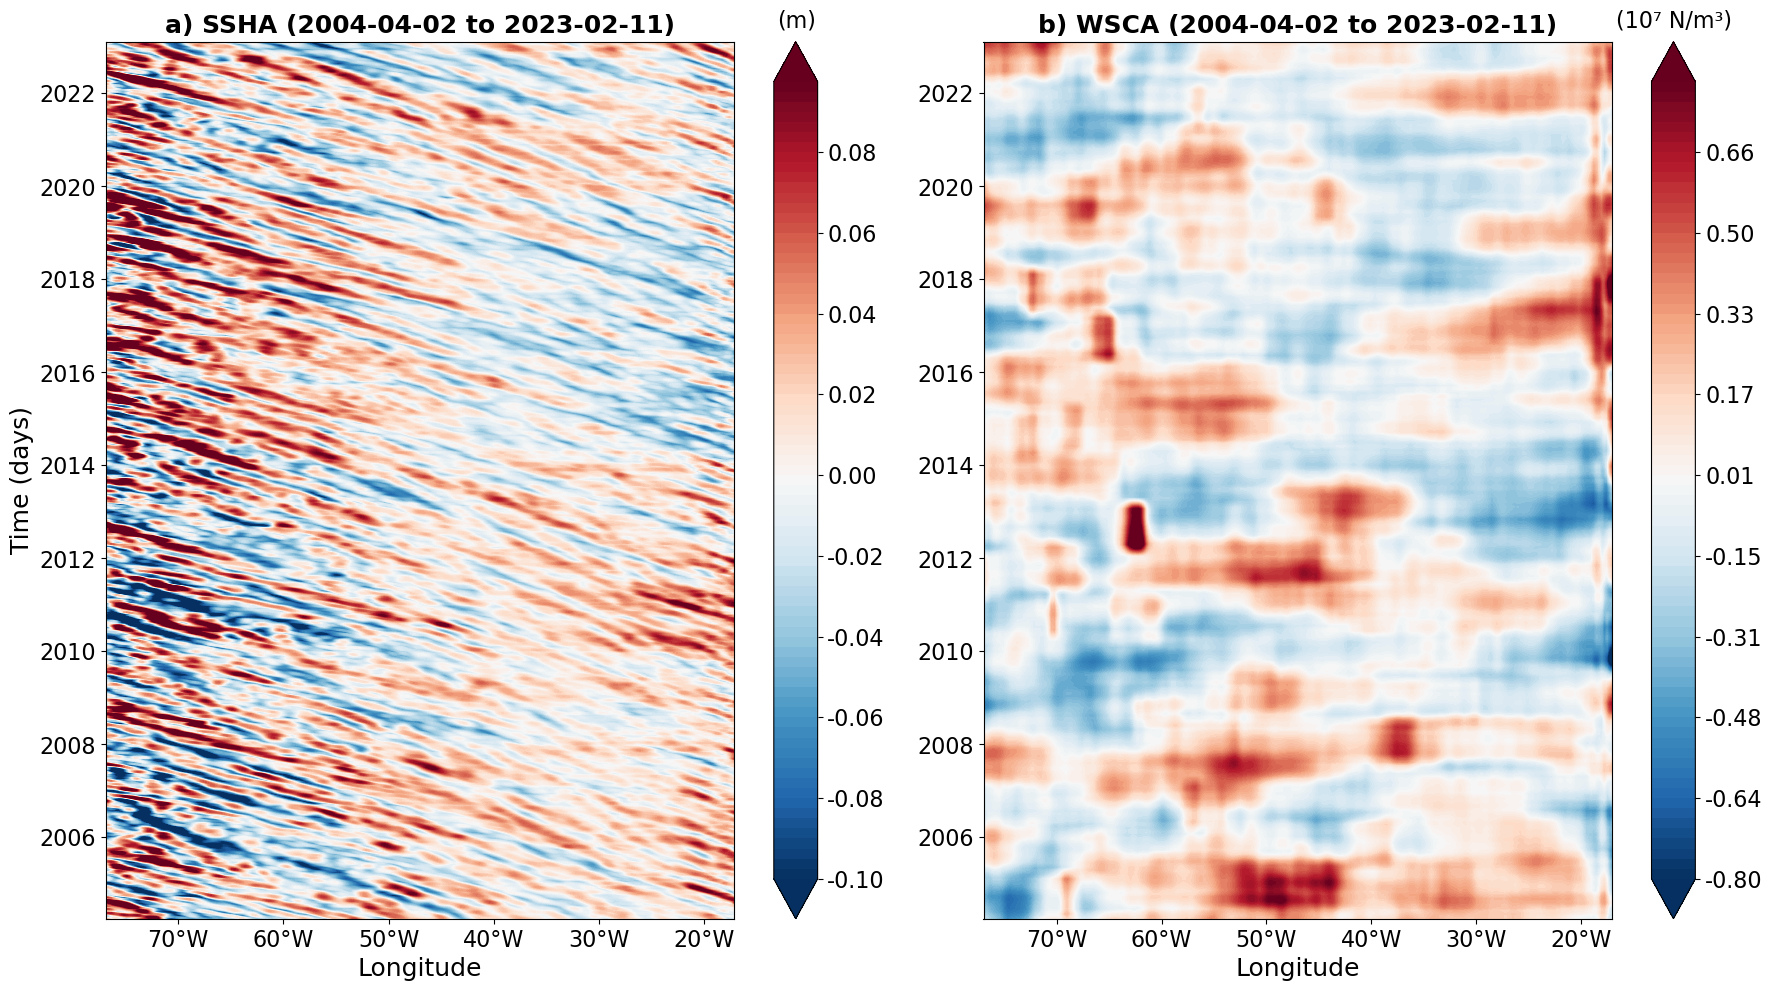

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, FormatStrFormatter

def format_longitude(value, tick_number):
    degree = int(np.abs(value))
    return f"{degree}°W"

ssha_start_time = ssha_deseasonalized['time'].values[0]
ssha_end_time = ssha_deseasonalized['time'].values[-1]

wsc_filtered_full_period = curl_tau_filtered_3m_1year.sel(time=slice(ssha_start_time, ssha_end_time))

ssha_filtered_longitude = ssha_deseasonalized.sel(longitude=slice(-77, -17))

fig, axs = plt.subplots(1, 2, figsize=(18, 10))
ssha_filtered_2004_2023 = ssha_filtered_longitude.sel(time=slice('2004-04-02 00:00:00', '2023-02-11 00:00:00'))  # Filter SSHA data for 2004 to 2023

contour_ssha_2004_2023 = axs[0].contourf(ssha_filtered_2004_2023['longitude'], 
                                         ssha_filtered_2004_2023['time'].values, 
                                         ssha_filtered_2004_2023.values, 
                                         levels=levels_ssha, cmap=cmap_ssha, extend='both')

cbar_ssha_2004_2023 = plt.colorbar(contour_ssha_2004_2023, ax=axs[0], orientation='vertical')
cbar_ssha_2004_2023.ax.tick_params(labelsize=16)
cbar_ssha_2004_2023.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

axs[0].set_xlabel('Longitude', fontsize=18)
axs[0].set_ylabel('Time (days)', fontsize=18)
axs[0].xaxis.set_major_formatter(FuncFormatter(format_longitude))
axs[0].set_title('a) SSHA (2004-04-02 to 2023-02-11)', fontsize=18, fontweight='bold')
axs[0].tick_params(axis='both', which='major', labelsize=16)

wsc_filtered_2004_2022 = curl_tau_filtered_3m_1year.sel(time=slice('2004-04-02 00:00:00', '2023-02-11 00:00:00'))  # Filter WSC data for 2004 to 2022

contour_wsc_2004_2022 = axs[1].contourf(wsc_filtered_2004_2022.longitude, 
                                        wsc_filtered_2004_2022.time, 
                                        wsc_filtered_2004_2022, 
                                        levels=levels_wsc, cmap=cmap_wsc, extend='both')

cbar_wsc_2004_2022 = plt.colorbar(contour_wsc_2004_2022, ax=axs[1], orientation='vertical')
cbar_wsc_2004_2022.ax.tick_params(labelsize=16)
cbar_wsc_2004_2022.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

axs[1].set_xlabel('Longitude', fontsize=18)
axs[1].xaxis.set_major_formatter(FuncFormatter(format_longitude))
axs[1].set_title('b) WSCA (2004-04-02 to 2023-02-11)', fontsize=18, fontweight='bold')
axs[1].tick_params(axis='both', which='major', labelsize=16)

axs[0].text(1.098, 1.01, '(m)', color='black', fontsize=16, 
            ha='center', va='bottom', transform=axs[0].transAxes)

axs[1].text(1.098, 1.01, '(10⁷ N/m³)', color='black', fontsize=16, 
            ha='center', va='bottom', transform=axs[1].transAxes)

plt.tight_layout()
plt.show()


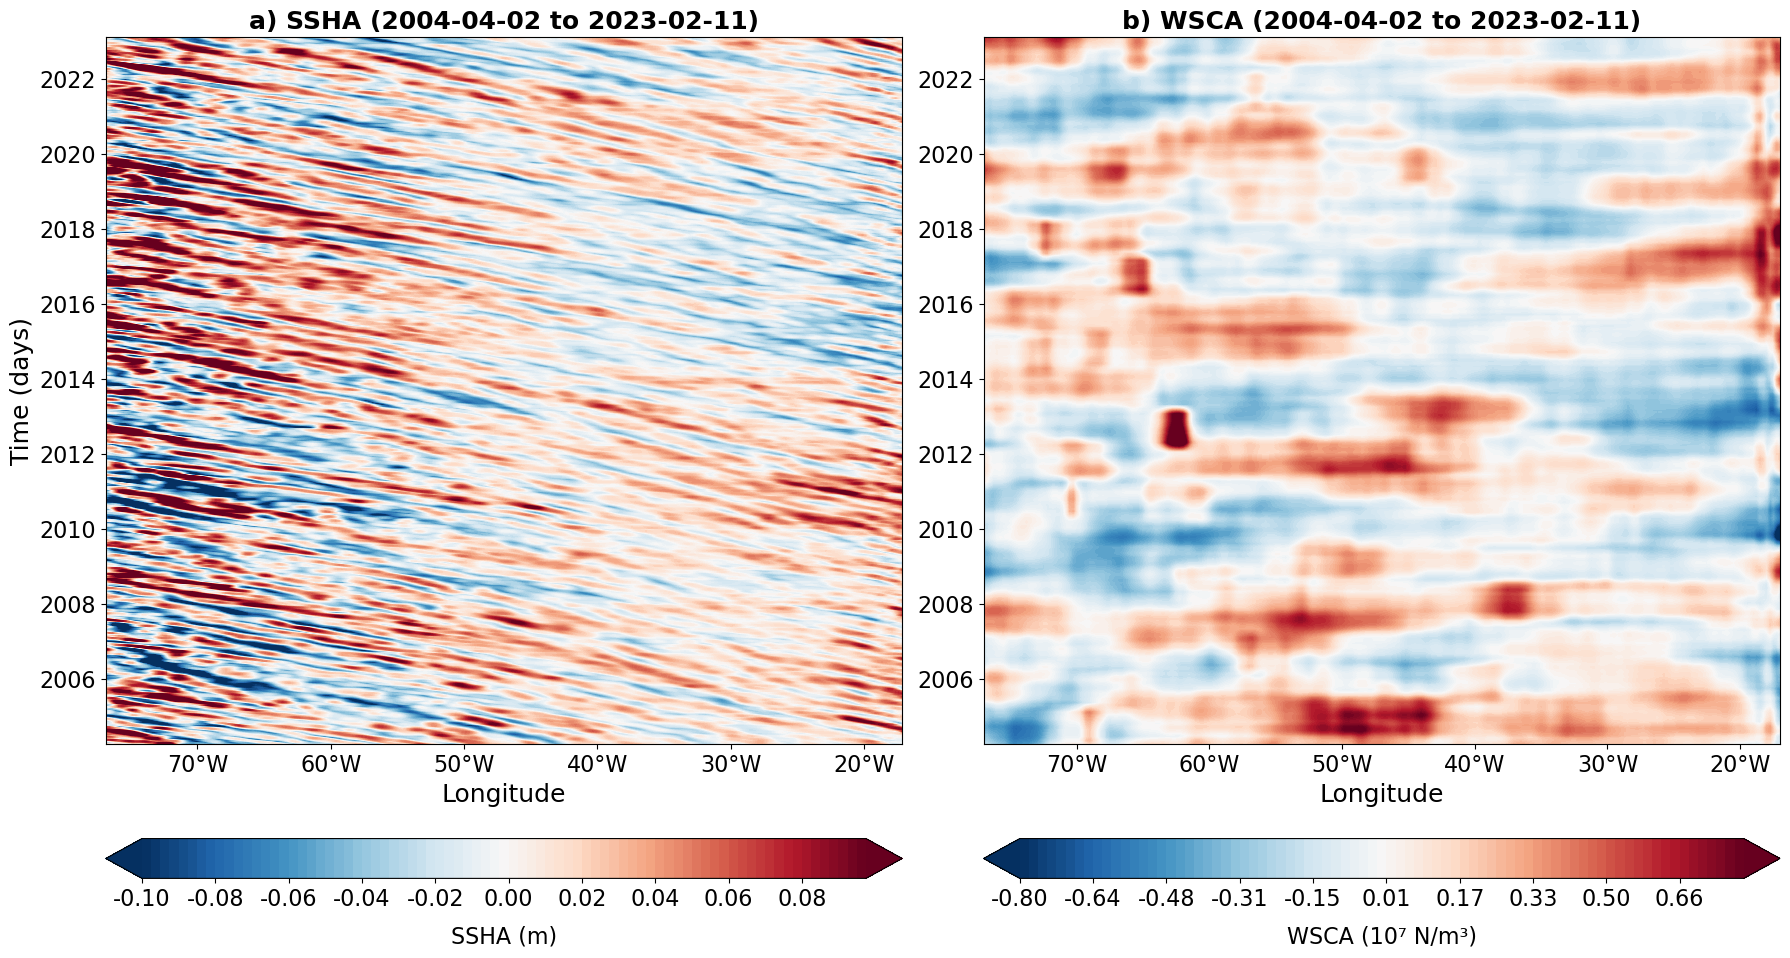

In [37]:
from matplotlib.ticker import FormatStrFormatter


fig, axs = plt.subplots(1, 2, figsize=(18, 10)) 

ssha_filtered_2004_2023 = ssha_filtered_longitude.sel(time=slice('2004-04-02 00:00:00', '2023-02-11 00:00:00'))  # Filter SSHA data for 2004 to 2023

contour_ssha_2004_2023 = axs[0].contourf(ssha_filtered_2004_2023['longitude'], 
                                         ssha_filtered_2004_2023['time'].values, 
                                         ssha_filtered_2004_2023.values, 
                                         levels=levels_ssha, cmap=cmap_ssha, extend='both')

cbar_ssha_2004_2023 = plt.colorbar(contour_ssha_2004_2023, ax=axs[0], orientation='horizontal', shrink=1, pad=0.1)
cbar_ssha_2004_2023.ax.tick_params(labelsize=16)
cbar_ssha_2004_2023.ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))  # Ensure tick labels have %.2f format
cbar_ssha_2004_2023.set_label('SSHA (m)', fontsize=16, labelpad=10, loc='center')

axs[0].set_xlabel('Longitude', fontsize=18)
axs[0].set_ylabel('Time (days)', fontsize=18)
axs[0].xaxis.set_major_formatter(FuncFormatter(format_longitude))
axs[0].set_title('a) SSHA (2004-04-02 to 2023-02-11)', fontsize=18, fontweight='bold')
axs[0].tick_params(axis='both', which='major', labelsize=16)

wsc_filtered_2004_2022 = curl_tau_filtered_3m_1year.sel(time=slice('2004-04-02 00:00:00', '2023-02-11 00:00:00'))  # Filter WSC data for 2004 to 2022

contour_wsc_2004_2022 = axs[1].contourf(wsc_filtered_2004_2022.longitude, 
                                        wsc_filtered_2004_2022.time, 
                                        wsc_filtered_2004_2022, 
                                        levels=levels_wsc, cmap=cmap_wsc, extend='both')

cbar_wsc_2004_2022 = plt.colorbar(contour_wsc_2004_2022, ax=axs[1], orientation='horizontal', shrink=1, pad=0.1)
cbar_wsc_2004_2022.ax.tick_params(labelsize=16)
cbar_wsc_2004_2022.ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))  # Ensure tick labels have %.2f format
cbar_wsc_2004_2022.set_label('WSCA (10⁷ N/m³)', fontsize=16, labelpad=10, loc='center')
axs[1].set_xlabel('Longitude', fontsize=18)
axs[1].xaxis.set_major_formatter(FuncFormatter(format_longitude))
axs[1].set_title('b) WSCA (2004-04-02 to 2023-02-11)', fontsize=18, fontweight='bold')
axs[1].tick_params(axis='both', which='major', labelsize=16)
plt.tight_layout()
plt.show()
